In [3]:
from transformers import ViTImageProcessor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


full_train_ds = datasets.ImageFolder('./train/train/')
print(full_train_ds)
# Splitting the dataset into train and validation sets
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

train_ds = 
val_ds = processor(val_ds, return_tensors='pt')
# Setup data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


Dataset ImageFolder
    Number of datapoints: 2026
    Root location: ./train/train/


AttributeError: 'Subset' object has no attribute 'map'

In [2]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

model.classifier = torch.nn.Linear(model.config.hidden_size, 5)


C:\Users\germa\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Record training loss and accuracy
    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Record validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch [1/5], Loss: 0.3955, Accuracy: 88.09%, Val Loss: 0.1732, Val Accuracy: 95.07%
Epoch [2/5], Loss: 0.1120, Accuracy: 95.80%, Val Loss: 0.1466, Val Accuracy: 95.07%
Epoch [3/5], Loss: 0.0811, Accuracy: 96.54%, Val Loss: 0.1452, Val Accuracy: 94.83%
Epoch [4/5], Loss: 0.0742, Accuracy: 97.10%, Val Loss: 0.1491, Val Accuracy: 95.32%
Epoch [5/5], Loss: 0.0665, Accuracy: 96.54%, Val Loss: 0.1328, Val Accuracy: 95.07%


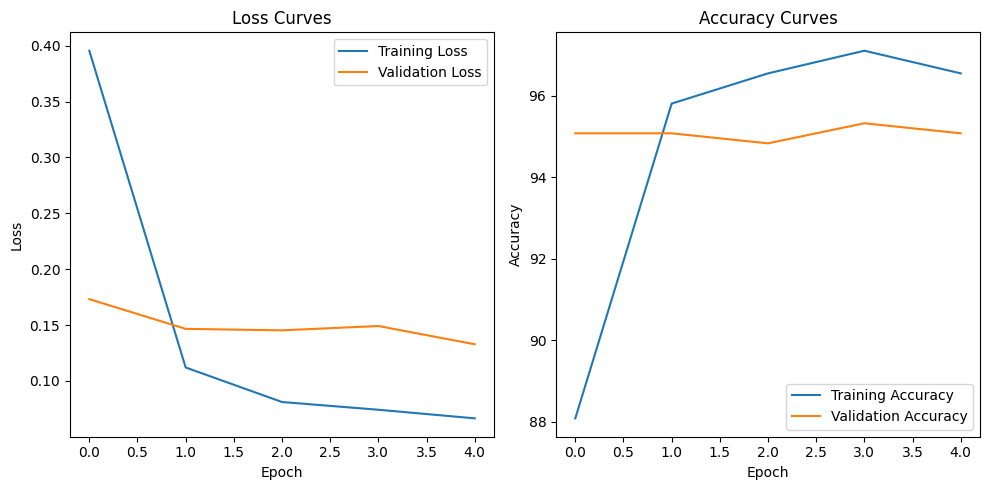

In [4]:
def plotLosses(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    ax1.plot(history['loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['accuracy'], label='Training Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    fig.tight_layout()
    plt.show()

# Call the plot function with the history dictionary
plotLosses(history)


In [5]:
import numpy as np

test_ds = datasets.ImageFolder('./test/', transform=transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model.eval()  # Set the model to evaluation mode

all_predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        all_predictions.extend(predicted.cpu().numpy())

# all_predictions now contains the predicted class indices for each test image

import pandas as pd

# Assuming the structure is something like './test/class_name/filename.jpg'
ids = [fp.split('\\')[-1].split('.')[0] for fp, _ in test_ds.imgs]

submission_df = pd.DataFrame({
    'id': ids,
    'label': all_predictions
})
submission_df.to_csv('newsubmission.csv', index=False)